In [1]:
from tensorflow.keras.models import load_model

# Load model from file
pen_to_pixel = load_model("pen_to_pixel.keras")
from tensorflow.keras import datasets, layers, models


2025-08-24 01:25:32.886449: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 01:25:32.920757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 01:25:33.732048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1755978934.828658   84302 gpu_device.cc:2020] Created device /job:localhost/rep

IndentationError: unindent does not match any outer indentation level (<string>, line 15)

In [21]:
plt.imshow(tf.transpose(tf.image.flip_left_right(image), perm=[1,0]), cmap='gray')
plt.title(f"Label: {img_label}")
plt.axis('off')
plt.show()

NameError: name 'image' is not defined

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint

# Load EMNIST Digits
ds_train, ds_test = tfds.load('emnist/digits', split=['train', 'test'], as_supervised=True)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0           # normalize
    image = tf.image.resize(image, [64,64])              # resize
    image = tf.expand_dims(image, -1)                    # add channel dimension
    return image, label

# Shuffle and batch the training dataset
ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(buffer_size=10000, seed=42)  # shuffle the dataset
ds_train = ds_train.batch(128).prefetch(tf.data.AUTOTUNE)

# Test dataset (no shuffle needed)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

# Build CNN+RNN model
inputs = layers.Input(shape=(64,64,1))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)

# Compute the new shape dynamically for RNN
shape = x.shape  # TensorShape(None, 15, 15, 64)  after two MaxPool
timesteps = shape[1]*shape[2]  # 15*15=225
features  = shape[3]           # 64

x = layers.Reshape((timesteps, features))(x)
x = layers.SimpleRNN(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

pen_to_pixel = models.Model(inputs, outputs)
pen_to_pixel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pen_to_pixel.summary()

checkpoint = ModelCheckpoint("pen_to_pixel.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             verbose=1)

# Train
pen_to_pixel.fit(ds_train, epochs=20, validation_data=ds_test,callbacks=[checkpoint])

# Evaluate
test_loss, test_acc = pen_to_pixel.evaluate(ds_test)
print(f"EMNIST Digits Test Accuracy: {test_acc*100:.2f}%")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 196, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,426 (204.79 KB)

 Trainable params: 52,426 (204.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-08-24 20:04:10.111967: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ad1bc006e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-24 20:04:10.111985: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-08-24 20:04:10.147150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-24 20:04:10.308977: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-24 20:04:10.357885: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 20:04:10.357921: I e

   2/1875 ━━━━━━━━━━━━━━━━━━━━ 2:10 70ms/step - accuracy: 0.0996 - loss: 2.3043  

I0000 00:00:1756046060.061991    4593 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6222 - loss: 1.1057

2025-08-24 20:05:38.079471: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 20:05:38.079500: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 20:05:38.079511: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 20:05:39.138748: I external/l


Epoch 1: val_accuracy improved from None to 0.81785, saving model to pen_to_pixel.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 91s 43ms/step - accuracy: 0.7548 - loss: 0.7483 - val_accuracy: 0.8178 - val_loss: 0.5636
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8764 - loss: 0.4116
Epoch 2: val_accuracy improved from 0.81785 to 0.91953, saving model to pen_to_pixel.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.8929 - loss: 0.3650 - val_accuracy: 0.9195 - val_loss: 0.2712
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4539 - loss: 2.0700
Epoch 3: val_accuracy did not improve from 0.91953
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 39ms/step - accuracy: 0.5676 - loss: 1.3298 - val_accuracy: 0.6998 - val_loss: 0.8788
Epoch 4/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7131 - loss: 0.8428
Epoch 4: val_accuracy did not improve from 0.91953
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.7400 - loss: 0.7751 - val_acc

In [1]:
import tensorflow as tf
print(tf.__version__)


2025-08-24 12:06:27.836869: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 12:06:28.038561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 12:06:29.033889: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.20.0


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds
import string

# ============================
# Load EMNIST ByClass (62 classes: 0–9, A–Z, a–z)
# ============================
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# ============================
# Preprocessing
# ============================
IMG_SIZE = 64
BATCH_SIZE = 128

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.expand_dims(image, -1)  # add channel dimension
    return image, label

ds_train = ds_train.map(preprocess).shuffle(50000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

NUM_CLASSES = ds_info.features["label"].num_classes  # should be 62

# ============================
# Model
# ============================
def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

pen_to_pixel = build_model()
pen_to_pixel.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# ============================
# Checkpoint
# ============================
checkpoint = ModelCheckpoint(
    "pen_to_pixel.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# ============================
# Training
# ============================
history = pen_to_pixel.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5,
    callbacks=[checkpoint]
)

# ============================
# Evaluation
# ============================
pen_to_pixel = tf.keras.models.load_model("pen_to_pixel.keras")
test_loss, test_acc = pen_to_pixel.evaluate(ds_test)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")


2025-08-24 22:59:07.793665: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 22:59:07.830536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 22:59:08.634753: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1756056549.875858   60734 gpu_device.cc:2020] Created device /job:localhost/rep

Epoch 1/5


2025-08-24 22:59:11.533243: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-24 22:59:12.082716: I external/local_xla/xla/service/service.cc:163] XLA service 0x7b6a0c0107b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-24 22:59:12.082758: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-08-24 22:59:12.117083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-24 22:59:12.311830: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-24 22:59:12.404291: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficien

   2/5453 ━━━━━━━━━━━━━━━━━━━━ 7:35 84ms/step - accuracy: 0.0684 - loss: 7.8617   

I0000 00:00:1756056560.485760   60898 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5452/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6989 - loss: 1.0821

2025-08-24 23:06:38.057694: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 23:06:38.530792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1334', 4 bytes spill stores, 4 bytes spill loads

2025-08-24 23:06:38.537861: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_880', 12 bytes spill stores, 12 bytes spill loads

2025-08-24 23:06:38.709170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1506', 112 byte

5453/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6990 - loss: 1.0820

2025-08-24 23:06:58.831052: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 12 bytes spill stores, 12 bytes spill loads

2025-08-24 23:06:59.079409: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 60 bytes spill stores, 60 bytes spill loads

2025-08-24 23:06:59.367433: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 11756 bytes spill stores, 11088 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.85116, saving model to pen_to_pixel.keras
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 471s 84ms/step - accuracy: 0.7702 - loss: 0.7409 - val_accuracy: 0.8512 - val_loss: 0.4165
Epoch 2/5
1297/5453 ━━━━━━━━━━━━━━━━━━━━ 5:32 80ms/step - accuracy: 0.8280 - loss: 0.5137

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 🔹 Load EMNIST Letters dataset (you can replace with 'mnist')
ds = tfds.load("emnist/byclass", split="train", as_supervised=True)

# 🔹 Take a single example
for image, label in ds.take(10):
    plt.imshow(tf.squeeze(image), cmap="gray")
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")
    plt.show()


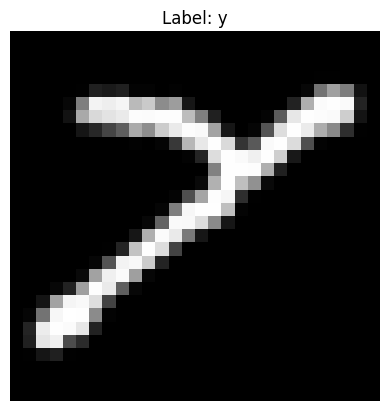

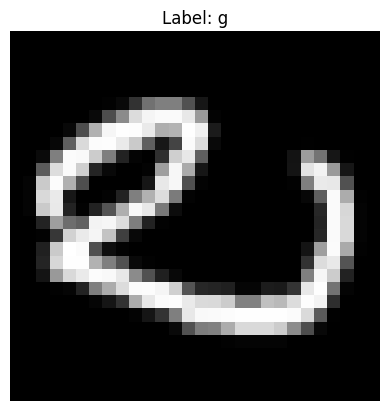

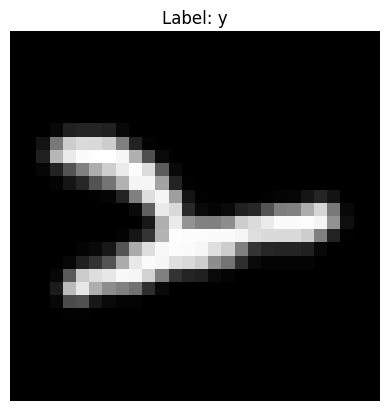

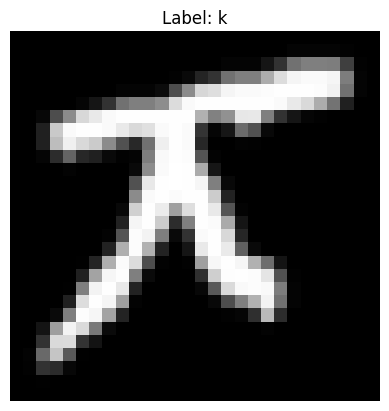

2025-08-24 19:36:05.399423: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


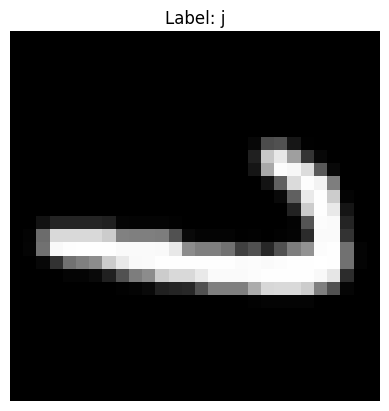

2025-08-24 19:36:05.433256: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import string

# 🔹 Load EMNIST Letters dataset
ds = tfds.load("emnist/letters", split="train", as_supervised=True)

# 🔹 Map label numbers (1–26) to letters (a–z)
label_to_char = {i+1: c for i, c in enumerate(string.ascii_lowercase)}

# 🔹 Take a single example
for image, label in ds.take(5):
    plt.imshow(tf.squeeze(image), cmap="gray")
    plt.title(f"Label: {label_to_char[label.numpy()]}")
    plt.axis("off")
    plt.show()



In [2]:
import cv2
print(cv2.__version__)


4.12.0


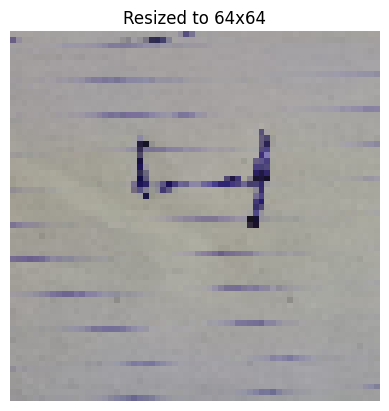

In [4]:
import cv2
import matplotlib.pyplot as plt

# Read image
img = cv2.imread('/home/mudda/Downloads/4.jpeg')

# Convert BGR -> RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize to 28x28
img_resized = cv2.resize(img_rgb, (64, 64))

# Show resized image
plt.imshow(img_resized, cmap='gray')
plt.title("Resized to 64x64")
plt.axis("off")
plt.show()



In [6]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load model
pen_to_pixel = load_model("pen_to_pixel.keras")

# Convert to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ✅ Resize to 64x64 (not 28x28)
img_resized = cv2.resize(img_gray, (64, 64))

# Normalize (0–1 range)
img_normalized = img_resized / 255.0

# ✅ Add channel and batch dimensions → (1, 64, 64, 1)
img_ready = img_normalized.reshape(1, 64, 64, 1)

# Predict
pred = pen_to_pixel.predict(img_ready)
print("Predicted class:", pred.argmax())



2025-08-24 12:09:42.898899: I external/local_xla/xla/service/service.cc:163] XLA service 0x494bf8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-24 12:09:42.898921: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-08-24 12:09:42.912645: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-24 12:09:42.961889: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicted class: 4


I0000 00:00:1756017583.433650    5976 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [3]:
import os
print(os.getcwd())

/home/mudda


In [ ]:
/home/mudda/Downloads/

In [ ]:

if img is None:
    print("Image not found or failed to load!")
else:
    print("Image shape:", img.shape)

In [14]:
import pandas as pd
data = pd.read_csv("A_Z Handwritten Data.csv").astype("float32")
print(data.shape)


(0, 1)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint

# Load EMNIST Digits
ds_train, ds_test = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0           # normalize
    image = tf.image.resize(image, [64,64])              # resize
    image = tf.expand_dims(image, -1)                    # add channel dimension
    return image, label

# Shuffle and batch the training dataset
ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(buffer_size=10000, seed=42)  # shuffle the dataset
ds_train = ds_train.batch(128).prefetch(tf.data.AUTOTUNE)

# Test dataset (no shuffle needed)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

# Build CNN+RNN model
inputs = layers.Input(shape=(64,64,1))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)

# Compute the new shape dynamically for RNN
shape = x.shape  # TensorShape(None, 15, 15, 64)  after two MaxPool
timesteps = shape[1]*shape[2]  # 15*15=225
features  = shape[3]           # 64

x = layers.Reshape((timesteps, features))(x)
x = layers.SimpleRNN(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

pen_to_pixel = models.Model(inputs, outputs)
pen_to_pixel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pen_to_pixel.summary()

checkpoint = ModelCheckpoint("pen_to_pixel.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             verbose=1)

# Train
pen_to_pixel.fit(ds_train, epochs=100, validation_data=ds_test,callbacks=[checkpoint])

# Evaluate
test_loss, test_acc = pen_to_pixel.evaluate(ds_test)
print(f"EMNIST Digits Test Accuracy: {test_acc*100:.2f}%")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/mudda/tensorflow_datasets/emnist/letters/incomplete.8FOX6J_3.1.0/emnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/mudda/tensorflow_datasets/emnist/letters/incomplete.8FOX6J_3.1.0/emnist-test.tfrecord*...:   0…

Dataset emnist downloaded and prepared to /home/mudda/tensorflow_datasets/emnist/letters/3.1.0. Subsequent calls will reuse this data.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 196, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,426 (204.79 KB)

 Trainable params: 52,426 (204.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2025-08-24 12:16:19.639451: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-24 12:16:20.021522: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 12:16:20.021568: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 12:16:20.021592: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match

693/694 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0384 - loss: nan

2025-08-24 12:17:05.219320: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 12:17:05.219360: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 12:17:05.219380: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 12:17:05.219399: I external/l

694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0384 - loss: nan

2025-08-24 12:17:19.388585: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 12:17:19.388618: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 12:17:19.388630: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 12:17:20.696258: I external/l


Epoch 1: val_accuracy improved from None to 0.05405, saving model to pen_to_pixel.keras
694/694 ━━━━━━━━━━━━━━━━━━━━ 64s 76ms/step - accuracy: 0.0386 - loss: nan - val_accuracy: 0.0541 - val_loss: nan
Epoch 2/100
693/694 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0388 - loss: nan
Epoch 2: val_accuracy did not improve from 0.05405
694/694 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.0386 - loss: nan - val_accuracy: 0.0541 - val_loss: nan
Epoch 3/100
693/694 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0386 - loss: nan
Epoch 3: val_accuracy did not improve from 0.05405
694/694 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.0386 - loss: nan - val_accuracy: 0.0541 - val_loss: nan
Epoch 4/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0381 - loss: nan
Epoch 4: val_accuracy did not improve from 0.05405
694/694 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.0386 - loss: nan - val_accuracy: 0.0541 - val_loss: nan
Epoch 5/100
693/694 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/st

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint

# Load EMNIST Letters (26 classes: A–Z)
ds_train, ds_test = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0           # normalize
    image = tf.image.resize(image, [64,64])              # resize to 64x64
    image = tf.expand_dims(image, -1)                    # add channel dimension
    label = label - 1  # EMNIST Letters labels go from 1–26 → shift to 0–25
    return image, label

# Shuffle function
def shuffle_dataset(dataset, buffer_size=10000, seed=42):
    return dataset.shuffle(buffer_size=buffer_size, seed=seed, reshuffle_each_iteration=True)

# Apply preprocessing + shuffling
ds_train = ds_train.map(preprocess)
ds_train = shuffle_dataset(ds_train)                     # 🔥 shuffle added here
ds_train = ds_train.batch(128).prefetch(tf.data.AUTOTUNE)

# Test dataset (no shuffle needed)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

# Build stronger CNN+RNN model
inputs = layers.Input(shape=(64,64,1))

# CNN feature extractor
x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# Flatten to sequence for RNN
shape = x.shape  # (None, 8, 8, 128)
timesteps = shape[1] * shape[2]  # 8*8=64
features = shape[3]  # 128

x = layers.Reshape((timesteps, features))(x)

# RNN
x = layers.Bidirectional(layers.LSTM(128))(x)

# Dense classifier
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(26, activation='softmax')(x)

# Compile model
pen_to_pixel = models.Model(inputs, outputs)
pen_to_pixel.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

pen_to_pixel.summary()

# Checkpoint
checkpoint = ModelCheckpoint("pen_to_pixel.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             verbose=1)

# Train
pen_to_pixel.fit(ds_train, epochs=150, validation_data=ds_test, callbacks=[checkpoint])

# Evaluate
test_loss, test_acc = pen_to_pixel.evaluate(ds_test)
print(f"EMNIST Letters Test Accuracy: {test_acc*100:.2f}%")


2025-08-24 13:20:34.591453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 13:20:34.794610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 13:20:35.797648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1756021837.543771    3785 gpu_device.cc:2020] Created device /job:localhost/rep

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,210 (1.64 MB)

 Trainable params: 428,762 (1.64 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/150


2025-08-24 13:20:40.527638: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-24 13:20:40.677905: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5510 - loss: 1.4814
Epoch 1: val_accuracy improved from None to 0.86547, saving model to pen_to_pixel.keras
694/694 ━━━━━━━━━━━━━━━━━━━━ 59s 80ms/step - accuracy: 0.7396 - loss: 0.8383 - val_accuracy: 0.8655 - val_loss: 0.4035
Epoch 2/150
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8921 - loss: 0.3320
Epoch 2: val_accuracy improved from 0.86547 to 0.90345, saving model to pen_to_pixel.keras
694/694 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.9004 - loss: 0.3079 - val_accuracy: 0.9034 - val_loss: 0.2839
Epoch 3/150
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9175 - loss: 0.2518
Epoch 3: val_accuracy improved from 0.90345 to 0.91034, saving model to pen_to_pixel.keras
694/694 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.9209 - loss: 0.2446 - val_accuracy: 0.9103 - val_loss: 0.2646
Epoch 4/150
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9288 - loss: 0.2143
Epoch 4: val_accuracy did not imp

In [8]:
from tensorflow.keras.utils import plot_model

# Save model architecture as an image
plot_model(pen_to_pixel, to_file="pen_to_pixel.png", show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load model from file
pen_to_pixel = load_model("pen_to_pixel.keras")

# Assuming you trained with: history = model.fit(...)
plt.plot(pen_to_pixel.history['accuracy'], label='Train Accuracy')
plt.plot(pen_to_pixel.history['val_accuracy'], label='Validation Accuracy')
plt.plot(pen_to_pixel.history['loss'], label='Train Loss')
plt.plot(pen_to_pixel.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


AttributeError: 'Functional' object has no attribute 'history'

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers as L, models, callbacks

# 0) GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print(f"✅ TensorFlow sees {len(gpus)} GPU(s)")
    except Exception as e:
        print("GPU setup warning:", e)
else:
    print("⚠️ No GPU detected; training will run on CPU")

# 1) Load CSV
CSV_PATH = "/home/mudda/Downloads/archive/A_Z Handwritten Data.csv"
data = pd.read_csv(CSV_PATH)
print("Dataset shape:", data.shape)

# 2) Prepare features and labels
y = data.iloc[:, 0].astype("int32").values
X = data.iloc[:, 1:].astype("float32").values
X = X / 255.0
X = X.reshape(-1, 28, 28, 1)

# 3) Resize images to 64x64
X_resized = tf.image.resize(X, [64,64]).numpy()  # convert to NumPy array

# 4) Shuffle the dataset before splitting
rng = np.random.default_rng(42)
indices = np.arange(len(X_resized))
rng.shuffle(indices)
X_resized = X_resized[indices]
y = y[indices]

# 5) Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resized, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# 6) Dataset pipelines with shuffling
BATCH = 256
def make_ds(features, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(features), seed=42)  # shuffle dataset
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val, y_val)
test_ds  = make_ds(X_test, y_test)

# 7) Class weights
classes = np.unique(y_train)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("Class weights:", class_weights)

# 8) CNN+BiLSTM model with 64x64 input
def build_cnn_bilstm():
    inp = L.Input(shape=(64,64,1))
    x = L.Conv2D(32, 3, activation="relu")(inp)
    x = L.MaxPooling2D(2)(x)           # 64->32
    x = L.Conv2D(64, 3, activation="relu")(x)
    x = L.MaxPooling2D(2)(x)           # 32->15 approx
    timesteps = x.shape[1] * x.shape[2]
    features  = x.shape[3]
    x = L.Reshape((timesteps, features))(x)
    x = L.Bidirectional(L.LSTM(64))(x)
    x = L.Dropout(0.4)(x)
    x = L.Dense(128, activation="relu")(x)
    out = L.Dense(26, activation="softmax")(x)
    model = models.Model(inp, out)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

pen_to_pixel = build_cnn_bilstm()
pen_to_pixel.summary()

# 9) Callbacks with checkpoint
checkpoint_cb = callbacks.ModelCheckpoint(
    "pen_to_pixel.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)
early_stop_cb = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)
reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)
cbs = [checkpoint_cb, early_stop_cb, reduce_lr_cb]

# 10) Train
history = pen_to_pixel.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

# 11) Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

# 12) Classification report
y_pred = []
for xb, yb in test_ds:
    logits = model.predict(xb, verbose=0)
    y_pred.append(np.argmax(logits, axis=1))
y_pred = np.concatenate(y_pred)

letters = [chr(i+65) for i in range(26)]
print(classification_report(y_test, y_pred, target_names=letters, digits=4))

# 13) Show some predictions
idxs = np.random.choice(len(X_test), 6, replace=False)
plt.figure(figsize=(10,4))
for i, idx in enumerate(idxs,1):
    img = X_test[idx].squeeze()
    true_c = letters[y_test[idx]]
    pred_c = letters[y_pred[idx]]
    plt.subplot(2,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"T:{true_c} / P:{pred_c}")
plt.suptitle("Random Predictions")
plt.tight_layout()
plt.show()

# 14) Save final model



GPU setup warning: Physical devices cannot be modified after being initialized
Loading dataset from: /home/mudda/Downloads/archive/A_Z Handwritten Data.csv
Shape (rows, cols) should be about (372450, 785): (372450, 785)
Train: (297960, 28, 28, 1) Val: (37245, 28, 28, 1) Test: (37245, 28, 28, 1)
Class weights: {0: 1.0328977016674177, 1: 1.6527256994519757, 2: 0.6119506594756234, 3: 1.4135931910694461, 4: 1.2521853146853146, 5: 12.32258064516129, 6: 2.4859002169197395, 7: 1.9847592656737096, 8: 12.790178571428571, 9: 1.6867824551074477, 10: 2.5568942436412314, 11: 1.2363793289459488, 12: 1.1612118755699665, 13: 0.753550762756444, 14: 0.24773022049286642, 15: 0.7406449945065599, 16: 2.464516129032258, 17: 1.2385172376526532, 18: 0.2958564605653802, 19: 0.6368081795954657, 20: 0.4938165208773215, 21: 3.42498505678422, 22: 1.3283876202619682, 23: 2.2837783977680353, 24: 1.3192126165534708, 25: 2.3575396009051635}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,610 (951.60 KB)

 Trainable params: 243,610 (951.60 KB)

 Non-trainable params: 0 (0.00 B)


🔧 Training CNN…
Epoch 1/20


2025-08-23 23:44:29.714234: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c4700004e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-23 23:44:29.714262: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-08-23 23:44:29.741552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-23 23:44:30.603345: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_938', 64 bytes spill stores, 64 bytes spill loads

2025-08-23 23:44:30.740079: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_672', 1224 bytes spill stores, 1176 bytes 

  19/1164 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.0722 - loss: 3.2376

I0000 00:00:1755972873.372280   29544 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1163/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8042 - loss: 0.6807

2025-08-23 23:44:43.999760: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-23 23:44:44.831874: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_679', 16 bytes spill stores, 16 bytes spill loads

2025-08-23 23:44:44.900819: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_672', 60 bytes spill stores, 60 bytes spill loads

2025-08-23 23:44:45.000701: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_679', 420 byte

1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8043 - loss: 0.6804

2025-08-23 23:44:49.109763: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-23 23:44:49.449018: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 16 bytes spill stores, 16 bytes spill loads

2025-08-23 23:44:49.740477: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 420 bytes spill stores, 420 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.97503, saving model to best_cnn.keras
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9150 - loss: 0.2949 - val_accuracy: 0.9750 - val_loss: 0.0877 - learning_rate: 0.0010
Epoch 2/20
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9700 - loss: 0.0999
Epoch 2: val_accuracy improved from 0.97503 to 0.98435, saving model to best_cnn.keras
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9723 - loss: 0.0928 - val_accuracy: 0.9843 - val_loss: 0.0566 - learning_rate: 0.0010
Epoch 3/20
1159/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9775 - loss: 0.0717
Epoch 3: val_accuracy improved from 0.98435 to 0.98617, saving model to best_cnn.keras
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9784 - loss: 0.0695 - val_accuracy: 0.9862 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 4/20
1160/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9814 - loss: 0.0564
Epoch 4: val_accuracy improved from 0.98617 

Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 320)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,802 (921.10 KB)

 Trainable params: 235,802 (921.10 KB)

 Non-trainable params: 0 (0.00 B)


🔧 Training CNN+BiLSTM…
Epoch 1/20
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7308 - loss: 0.9425
Epoch 1: val_accuracy improved from None to 0.97637, saving model to best_cnn_bilstm.keras
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8825 - loss: 0.4088 - val_accuracy: 0.9764 - val_loss: 0.0837 - learning_rate: 0.0010
Epoch 2/20
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9649 - loss: 0.1180
Epoch 2: val_accuracy improved from 0.97637 to 0.98233, saving model to best_cnn_bilstm.keras
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9684 - loss: 0.1068 - val_accuracy: 0.9823 - val_loss: 0.0630 - learning_rate: 0.0010
Epoch 3/20
 735/1164 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9747 - loss: 0.0828